In [1]:
import time
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from feature_engine.selection import DropDuplicateFeatures, DropConstantFeatures, DropCorrelatedFeatures, RecursiveFeatureElimination
from sklearn.preprocessing import StandardScaler
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBClassifier, plot_importance

import Task_data_handler as Th

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

In [18]:
time_t = 20
num_features = 527

In [19]:
df, target, label, train_size = Th.get_df_preprocessed(time_limit=time_t)
print(df.shape, train_size)

(900, 3325) 600


<h2 font-family: comic>Removing unrelevant Columns</h2>

In [20]:
if num_features < 530:
    sel = DropConstantFeatures(tol=0.99, variables=None)
    sel.fit(df)
    df.drop(sel.features_to_drop_, axis=1, inplace=True)

    sel = DropDuplicateFeatures(variables=None)
    sel.fit(df)
    df.drop(sel.features_to_drop_, axis=1, inplace=True)

    sel = DropCorrelatedFeatures(threshold=0.90, method='spearman') # you can use other methods like kendall or spearman
    sel.fit(df)
    df.drop(sel.features_to_drop_, axis=1, inplace=True)

df.shape

(900, 527)

In [21]:
le = LabelEncoder()

xgb_model = XGBClassifier()
xgb_model.fit(df, le.fit_transform(target))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [22]:
importance_df = pd.DataFrame({'Features':df.columns, 'Importance': xgb_model.feature_importances_ })
importance_df.sort_values(by='Importance', inplace=True, ascending=False)

counter = 0
total_importance = 0
mean = importance_df.Importance.mean()
print('Total cols', len(importance_df), df.shape)
for i in range(len(importance_df)):
    total_importance += importance_df.iloc[i].Importance
    # if importance_df.iloc[i].Importance <= mean:
    if i >= num_features:
        df.drop(importance_df.iloc[i][0], axis=1, inplace=True)
        counter += 1
df.shape

Total cols 527 (900, 527)


(900, 527)

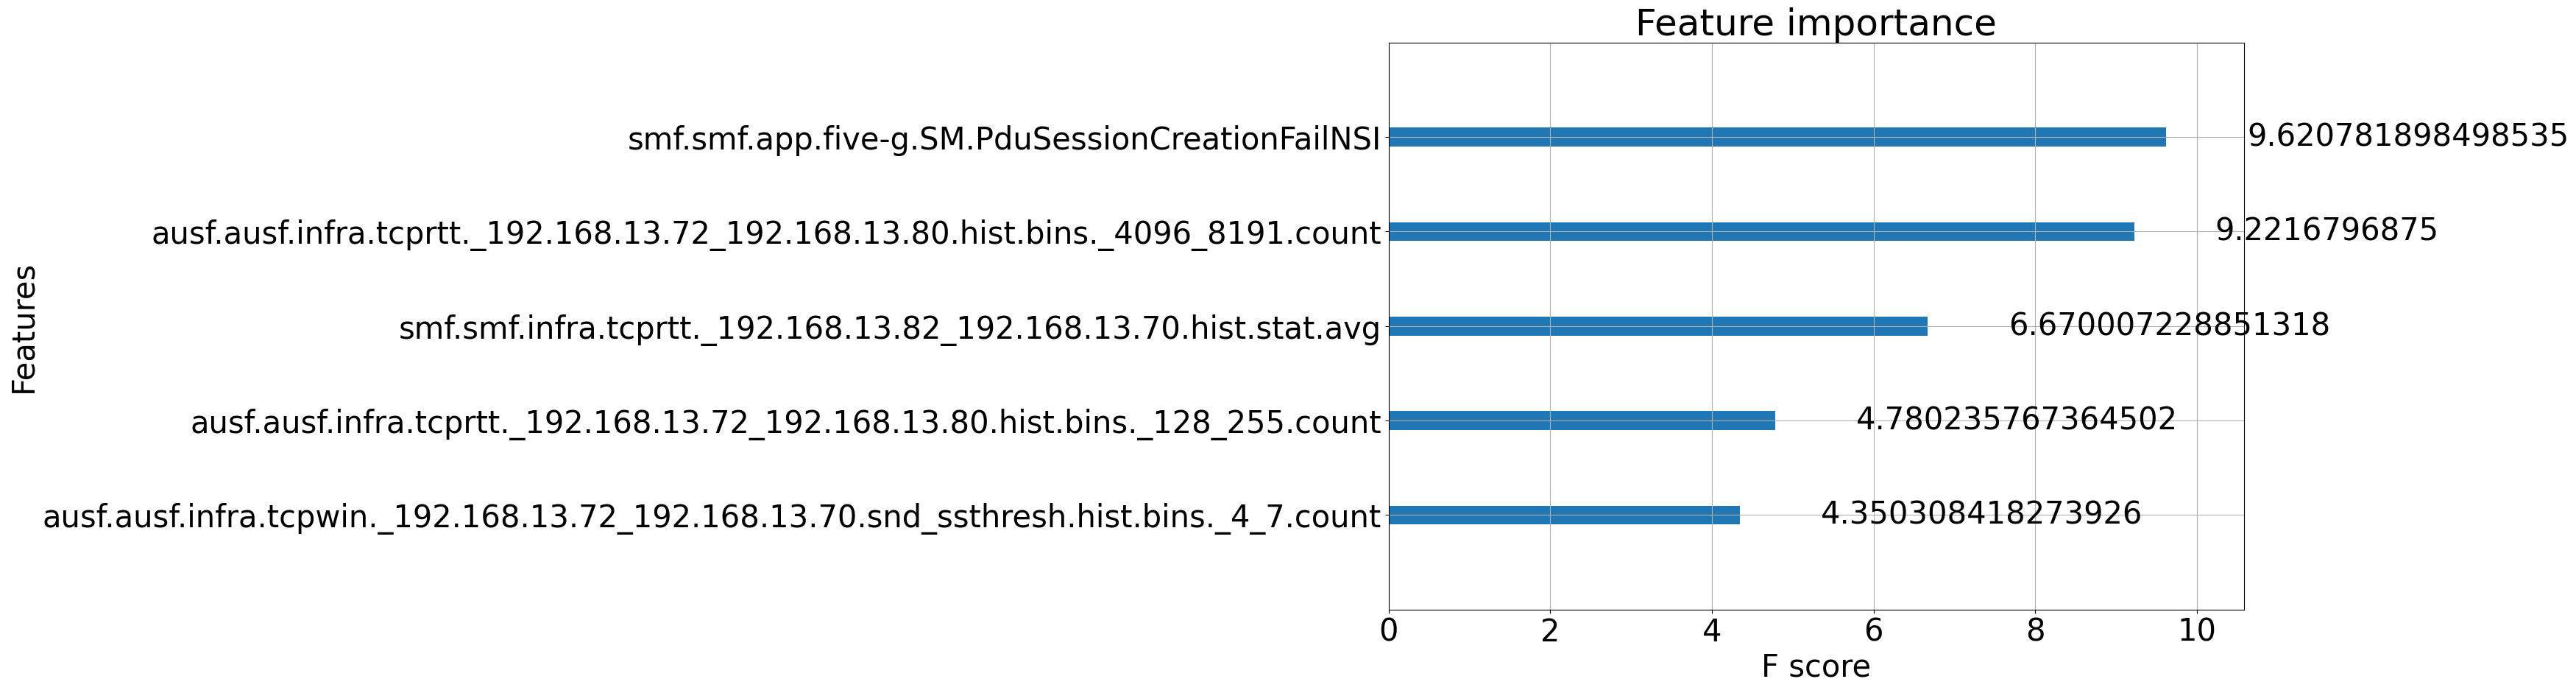

In [23]:
_, ax = plt.subplots(figsize=(15, 10))
plt.rc('font', size=30)
plt.rc('axes', labelsize=30) 
plot_importance(xgb_model, ax=ax, max_num_features=5, importance_type='gain')
plt.show()

In [24]:
X_train, y_train, X_test, y_test, train_label, test_label = Th.split(df, target, label, train_size)

In [25]:
X_train, train_label, y_train = Th.manage_imbalance(X_train, train_label, y_train)

# Models

In [26]:
def my_pred(pred, threshold=2):
    return (pred >= threshold).astype(int)

In [27]:
le = LabelEncoder()
svr_model = SVR(C=0.09, kernel='sigmoid')
bayes_model = BayesianRidge()
cat_model = CatBoostRegressor()
xgbr_model = XGBRegressor()
random_forest_model = RandomForestRegressor()

bayes_model.fit(X_train, y_train)
xgbr_model.fit(X_train, y_train)
svr_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)
cat_model.fit(X_train, y_train, verbose=250)

Learning rate set to 0.040267
0:	learn: 1.5254304	total: 171ms	remaining: 2m 50s
250:	learn: 0.5645637	total: 32s	remaining: 1m 35s
500:	learn: 0.2359254	total: 1m 5s	remaining: 1m 5s
750:	learn: 0.1150148	total: 1m 45s	remaining: 34.9s
999:	learn: 0.0616195	total: 2m 26s	remaining: 0us


In [28]:
y = test_label.factorize()[0]
models ={ 
        'SVR': svr_model, 
        'Cat': cat_model,
        'XGBR' : xgbr_model,
        'Bayesian Ridge' : bayes_model,
        'Random Forest': random_forest_model,
}

min_threshold = 0
max_threshold = 100
steps = 1
if time_t < 150:
        max_threshold = 300
        steps = 100

results = pd.DataFrame(columns=['Model', 'F1', 'Threshold', 'Accurancy'])
for i in range(min_threshold, max_threshold):
    for name, model in models.items():
        pred = my_pred(model.predict(X_test), threshold=i/steps)
        accur = accuracy_score(y, pred)
        tmp_df = pd.DataFrame([[name, f1_score(y, pred, average=None)[0], i/steps, accur]], columns=['Model', 'F1', 'Threshold', 'Accurancy'])
        results = pd.concat([results, tmp_df], ignore_index=True)
results = results.sort_values(by=['F1', 'Accurancy'], ascending = [False, False])
# results = results.sort_values('F1', ascending=False)
# df.sort_values(by = ['Rank', 'Age'], ascending = [True, False], na_position = 'first')

In [29]:
# Write a Summary of the findings for recording purposes
print('num features:', df.shape[1], 'Time:', time_t)
top_models = []
summary = pd.DataFrame(columns=['Model', 'F1', 'Threshold'])
i = 0
while len(top_models) < len(models):
    if results.iloc[i]['Model'] not in top_models:
        tmp_df = pd.DataFrame([[results.iloc[i]['Model'], results.iloc[i]['F1'], results.iloc[i]['Threshold']]], columns=['Model', 'F1', 'Threshold'])
        summary = pd.concat([summary, tmp_df], ignore_index=True)
        top_models.append(results.iloc[i]['Model'])
        
        if results.iloc[i]['Model'] == 'SVR':
            threshold = results.iloc[i]['Threshold']
    i += 1
summary

num features: 527 Time: 20


,Model,F1,Threshold
0,SVR,0.908714,0.56
1,Bayesian Ridge,0.872299,2.18
2,XGBR,0.872211,2.23
3,Random Forest,0.866667,2.75
4,Cat,0.859345,2.59


In [30]:
pd.set_option('display.max_rows', 20)
print('num features:', df.shape[1], 'Time:', time_t)
results

num features: 527 Time: 20


,Model,F1,Threshold,Accurancy
280,SVR,0.908714,0.56,0.853333
275,SVR,0.908333,0.55,0.853333
285,SVR,0.907216,0.57,0.850000
270,SVR,0.903766,0.54,0.846667
290,SVR,0.901639,0.58,0.840000
...,...,...,...,...
254,Random Forest,0.000000,0.50,0.250000
259,Random Forest,0.000000,0.51,0.250000
264,Random Forest,0.000000,0.52,0.246667
269,Random Forest,0.000000,0.53,0.246667


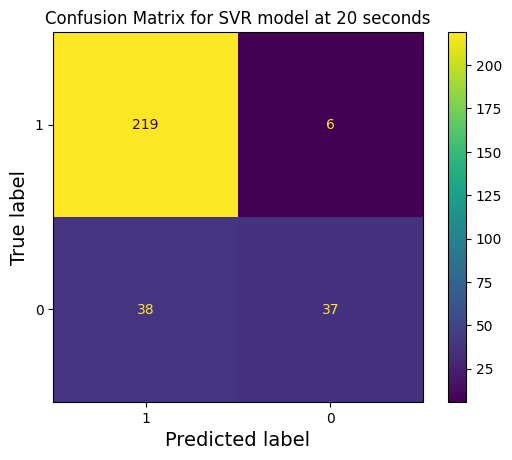

In [42]:
plt.rc('font', size=10)
plt.rc('axes', labelsize=14) 
cm = confusion_matrix(y, my_pred(svr_model.predict(X_test), threshold=threshold))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [1, 0], )
cm_display.plot()
plt.title(f'Confusion Matrix for SVR model at {time_t} seconds')
plt.show()

In [39]:
# Compare sklearn F1-Score calculations with my implememtation
def recall(matrix):
    [tp, fp], [fn, tn] = matrix
    return tp/(tp+fp)

def precision(matrix):
    [tp, fp], [fn, tn] = matrix
    return tp/(tp+fn)

def f1(matrix):
    return 2 * precision(matrix) * recall(matrix)/(precision(matrix)+recall(matrix))

print('Precision: ', precision(confusion_matrix(y, my_pred(svr_model.predict(X_test), threshold=threshold))))
print('Recall:    ', recall(confusion_matrix(y, my_pred(svr_model.predict(X_test), threshold=threshold))))
print('My implementation F1:   ', f1(confusion_matrix(y, my_pred(svr_model.predict(X_test), threshold=threshold))))
print('Sklearn implementation: ', f1_score(y, my_pred(svr_model.predict(X_test), threshold=threshold), average=None)[0])


Precision:  0.8521400778210116
Recall:     0.9733333333333334
My implementation F1:    0.9087136929460581
Sklearn implementation:  0.9087136929460581


In [33]:
print(classification_report(y, my_pred(svr_model.predict(X_test), threshold=threshold)))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91       225
           1       0.86      0.49      0.63        75

    accuracy                           0.85       300
   macro avg       0.86      0.73      0.77       300
weighted avg       0.85      0.85      0.84       300

